In [1]:
# import denpendency
import os 
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models 

In [2]:
dir = '/teamspace/studios/this_studio/Bio_sec/Extracted Faces/Extracted Faces'
random.seed(42)

def get_triplets(dir):
    triplets = []
    folders = list(os.listdir(dir))
    for folder in folders:
        folder_path = os.path.join(dir, folder)
        files = list(os.listdir(folder_path))
        for i, anchor_file in enumerate(files[:-1]):
            for _, positive_file in enumerate(files[i+1:]):
                
                negative_folder = random.choice(folders)
                while negative_folder == folder:
                    negative_folder = random.choice(folders)
                negative_file = random.choice(os.listdir(os.path.join(dir, negative_folder)))

                image_anchor = Image.open(os.path.join(dir, folder, anchor_file))
                image_positive = Image.open(os.path.join(dir, folder, positive_file))
                image_negative = Image.open(os.path.join(dir, negative_folder, negative_file))

                triplets.append((image_anchor, image_positive, image_negative))

    return triplets

triplets = get_triplets(dir)
print(len(triplets))

31990


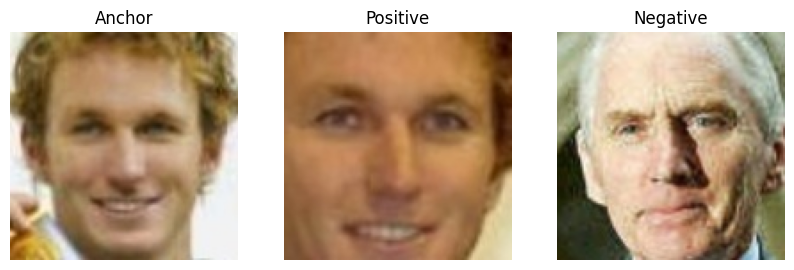

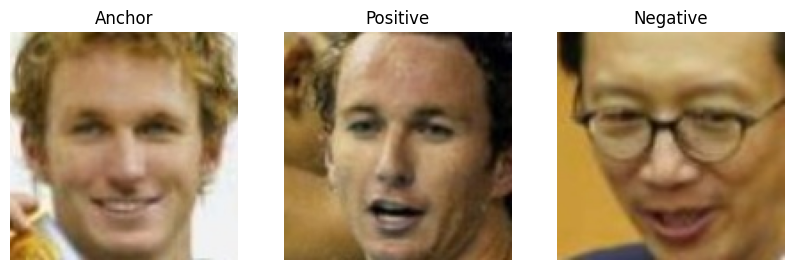

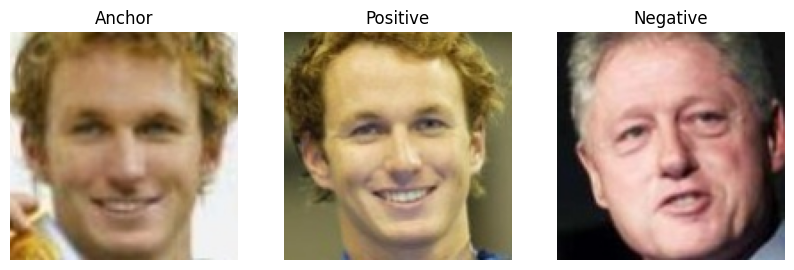

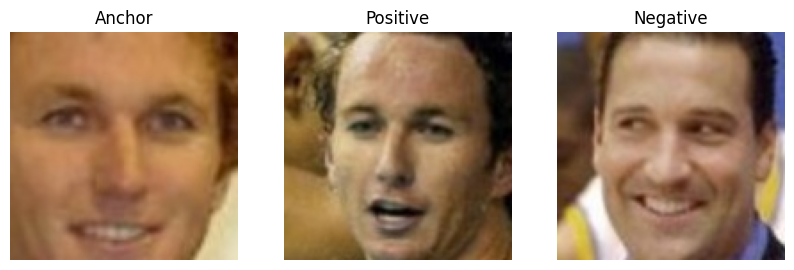

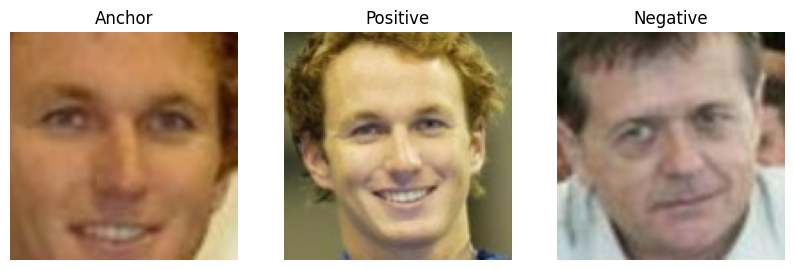

In [3]:
def show_triplet(triplet):

    figure = plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(triplet[0], cmap='gray')
    plt.title('Anchor')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(triplet[1], cmap='gray')
    plt.title('Positive')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(triplet[2], cmap='gray')
    plt.title('Negative')

    plt.axis('off')
    plt.show()
# afficher 5 examples de triplets(anchor, positive, negative)

for i in range(5):
    show_triplet(triplets[i])

In [4]:
class TripletDataset(Dataset):
    def __init__(self, triplets):
        self.triplets = triplets
        self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=torch.tensor([0.485, 0.456, 0.406]),std=torch.tensor([0.229, 0.224, 0.225])),
                transforms.Resize((128, 128))
            ])

    def __len__(self):
        return len(self.triplets)
    
    def __getitem__(self, idx):
        anchor, positive, negative = self.triplets[idx]
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
        return anchor, positive, negative

dataset = TripletDataset(triplets)

### split the datas into train and test split and get the dataloaders

In [5]:
# deviser le dataset en train_split et test_split
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)

batch_size = 128
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)
    

### define the model

In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = models.get_model('resnet18', weights = models.ResNet18_Weights.DEFAULT)
        # modify the finale fully connected layer with this sequential
        self.model.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128)
        )

        for name, param in self.model.named_parameters():
            if "fc" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

    def forward(self, x):
        x = self.model(x)
        x = F.normalize(x, p=2.0, dim=-1)  # L2 normalization
        return x
    
model = Model()
print('trainable parameters:',sum(p.numel() for p in model.parameters() if p.requires_grad))
print('non trainable parameters:',sum(p.numel() for p in model.parameters() if not p.requires_grad))



trainable parameters: 164736
non trainable parameters: 11176512


### define the loss function and optimizer

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
# define the loss function
loss_function = nn.TripletMarginLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001) # 3e-4
# optimizer = optim.Adam(model.parameters(), lr=3e-4) # 

epochs = 10
test_losses = []
train_losses = []

### train loop

In [8]:
for epoch in range(epochs):
    train_loss= 0
    model.train()
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()

        anchor, positive, negative = batch
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        with torch.autocast(device_type = 'cuda', dtype = torch.bfloat16):
            anchor_encoding = model(anchor)
            positive_encoding = model(positive)
            negative_encoding = model(negative)
            loss = loss_function(anchor_encoding, positive_encoding, negative_encoding)
        
        loss.backward()
        train_loss += loss.item() * batch_size
        optimizer.step()

    train_loss /= len(train_loader.dataset)

    train_losses.append(train_loss)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            anchor, positive, negative = batch
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            with torch.autocast(device_type = 'cuda', dtype = torch.bfloat16):
                anchor_encoding = model(anchor)
                positive_encoding = model(positive)
                negative_encoding = model(negative)
                loss = loss_function(anchor_encoding, positive_encoding, negative_encoding)
            
            test_loss += loss.item() * batch_size

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f"Epoch {epoch}, loss_train: {train_loss:.4f} Loss_test: {test_loss:.4f}")


Epoch 0, loss_train: 0.6097 Loss_test: 0.4558
Epoch 1, loss_train: 0.4079 Loss_test: 0.3675
Epoch 2, loss_train: 0.3286 Loss_test: 0.3148
Epoch 3, loss_train: 0.2842 Loss_test: 0.2852
Epoch 4, loss_train: 0.2492 Loss_test: 0.2628
Epoch 5, loss_train: 0.2312 Loss_test: 0.2511
Epoch 6, loss_train: 0.2120 Loss_test: 0.2393
Epoch 7, loss_train: 0.2016 Loss_test: 0.2265
Epoch 8, loss_train: 0.1887 Loss_test: 0.2248
Epoch 9, loss_train: 0.1799 Loss_test: 0.2174


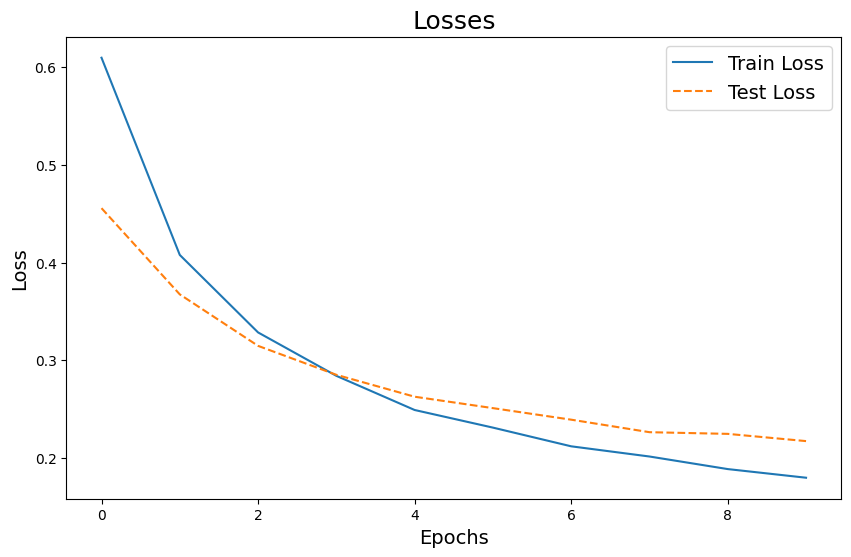

In [9]:
plt.figure(figsize=(10, 6))

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, "--", label='Test Loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Losses', fontsize=18)
plt.legend(fontsize=14)
plt.grid(False)
plt.show()

In [ ]:
save the trained model
save_chekp = '/teamspace/studios/this_studio/Bio_sec/model.pth'
torch.save(model.state_dict(), save_chekp)

In [10]:
# load the model
model_path = '/teamspace/studios/this_studio/Bio_sec/model.pth'
model = Model()
model.load_state_dict(torch.load(model_path))
model.to(device)

Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [11]:
def get_distances(face_list1, face_list2, model):
    # Ensure model and data are on the same device
    face_list1 = face_list1.to(device)
    face_list2 = face_list2.to(device)
    
    # Compute embeddings
    model.eval()
    with torch.no_grad():
        tensor1 = model(face_list1)
        tensor2 = model(face_list2)
    
    # Squared Euclidean distance
    distance = torch.sum((tensor1 - tensor2) ** 2, dim=-1)
    
    return distance.cpu().numpy()

# Initialize lists for distances
dap = []  # Distances for anchor-positive pairs
dan = []  # Distances for anchor-negative pairs

# Process all batches
for data in test_loader:
    anchor, positive, negative = data
    dist_ap = get_distances(anchor, positive, model)
    dist_an = get_distances(anchor, negative, model)
    
    dap.append(dist_ap.reshape(-1))
    dan.append(dist_an.reshape(-1))

# Convert to numpy arrays
dap = np.concatenate(dap)
dan = np.concatenate(dan)

# Calculate metrics across thresholds
seuils = np.linspace(min(dap.min(), dan.min()), 
                    max(dap.max(), dan.max()), 
                    1000)

frr, far, err = [], [], []
min_diff = float('inf')
eer = 0.5

for seuil in seuils:
    # Calculate error rates
    fa = np.sum(dap >= seuil) / len(dap)  # FRR
    fr = np.sum(dan <= seuil) / len(dan)  # FAR
    
    frr.append(fr)
    far.append(fa)
    err.append((fr + fa) / 2)
    
    # Find EER (exact intersection point)
    if abs(fr - fa) < min_diff:
        min_diff = abs(fr - fa)
        eer = (fr + fa) / 2

# Find threshold where FRR and FAR are closest
eer_index = np.argmin(np.abs(np.array(frr) - np.array(far)))
eer_threshold = seuils[eer_index]

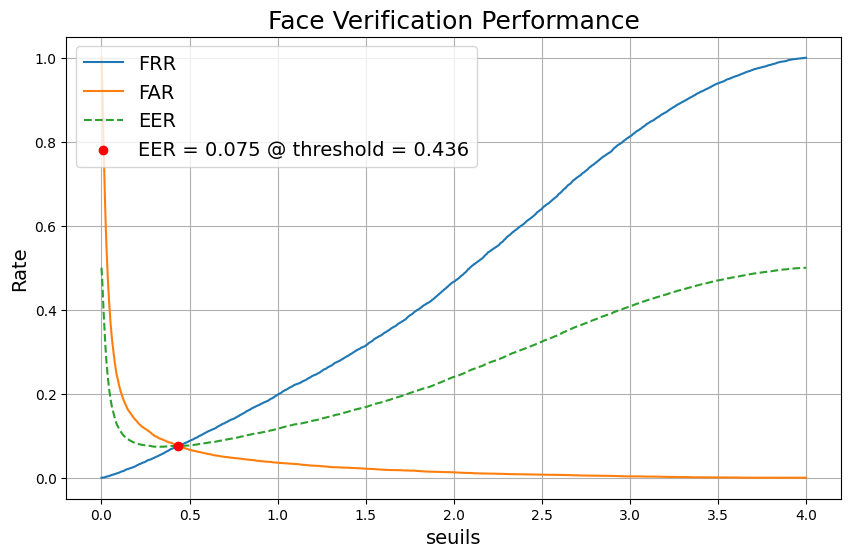

In [12]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(seuils, frr, label='FRR')
plt.plot(seuils, far, label='FAR')
plt.plot(seuils, err, '--', label='EER')

# Mark EER point
plt.scatter(eer_threshold, eer, color='red', zorder=5, 
           label=f'EER = {eer:.3f} @ threshold = {eer_threshold:.3f}')

plt.xlabel('seuils', fontsize=14)
plt.ylabel('Rate', fontsize = 14)
plt.title('Face Verification Performance', fontsize=18)
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()


In [13]:
# Print key metrics
print(f'Equal Error Rate (EER): {eer:.3%}')
print(f'Optimal Threshold: {eer_threshold:.3f}')
print(f'FRR at EER: {frr[eer_index]:.3%}')
print(f'FAR at EER: {far[eer_index]:.3%}')

Equal Error Rate (EER): 7.549%
Optimal Threshold: 0.436
FRR at EER: 7.549%
FAR at EER: 7.549%


## calcul de TID

In [14]:
def get_pred(face_list1, face_list2, model, seuil = 0.436):  #
    # Ensure model and data are on the same device
    face_list1 = face_list1.to(device)
    face_list2 = face_list2.to(device)
    
    # Compute embeddings
    model.eval()
    with torch.no_grad():
        tensor1 = model(face_list1)
        tensor2 = model(face_list2)
    
    # Squared Euclidean distance
    distance = torch.sum((tensor1 - tensor2) ** 2, dim=-1)
    prediction = torch.where(distance <= seuil, 1, 0)
    return prediction.cpu().numpy()
nbr_id = 0
for i, batch in enumerate(test_loader):
    anchor, positive, negative = batch
    prediction = get_pred(anchor, positive, model)
    nbr_id += np.sum(prediction, axis = -1) / len(prediction)

tid = (nbr_id / len(test_loader.dataset)) * 100
print(tid)

0.7128692560175055


# Tester sur une image

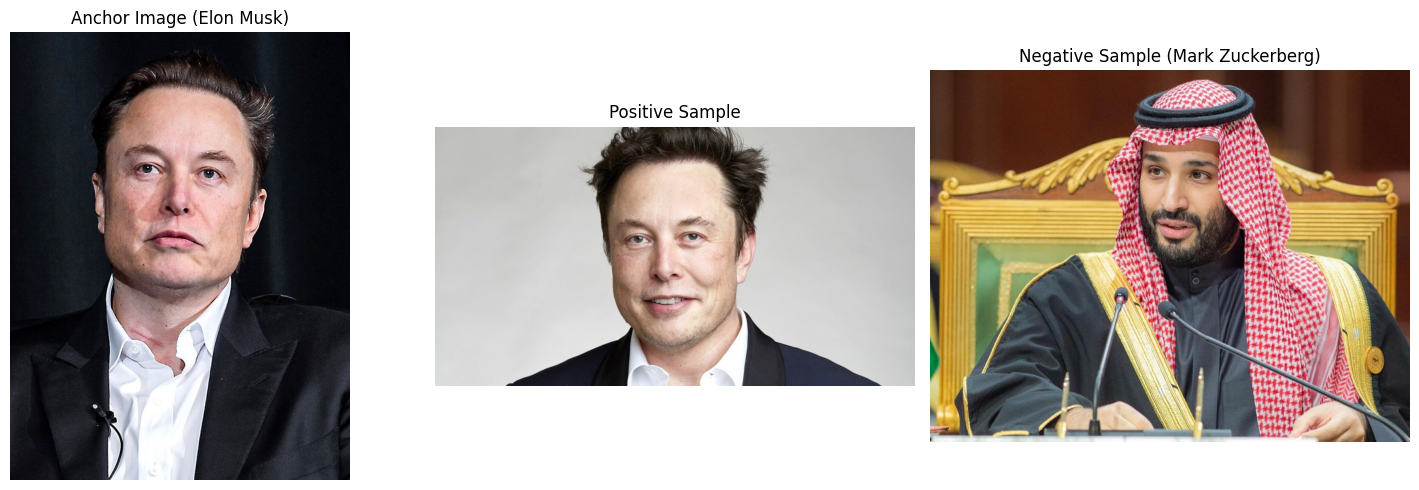

In [15]:
import matplotlib.image as mpimg

# Chemins des images
anchor_path = "/teamspace/studios/this_studio/Bio_sec/Elon_Musk_Colorado_2022_(cropped2).jpg"
pos_path = "/teamspace/studios/this_studio/Bio_sec/elon_pos.jpg"
neg_path = "/teamspace/studios/this_studio/Bio_sec/ibnsalman.jpg"
# neg_path = "/teamspace/studios/this_studio/Bio_sec/mark.jpg"

# Charger les images
anchor_img = mpimg.imread(anchor_path)
pos_img = mpimg.imread(pos_path)
neg_img = mpimg.imread(neg_path)

# Créer une figure avec 3 sous-graphiques
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Afficher les images
axs[0].imshow(anchor_img)
axs[0].set_title('Anchor Image (Elon Musk)')
axs[0].axis('off')

axs[1].imshow(pos_img)
axs[1].set_title('Positive Sample')
axs[1].axis('off')

axs[2].imshow(neg_img)
axs[2].set_title('Negative Sample (Mark Zuckerberg)')
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [16]:
import math
from mtcnn import MTCNN
import time

detector = MTCNN()

def euclidean(x1,y1,x2,y2):
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

def align(x1,y1,x2,y2,img):
    x3,y3 = 0,0
    adj,hyp = 0,euclidean(x1,y1,x2,y2)
    angle = 0

    if y1 > y2:
        x3,y3 = x1,y2
        adj = euclidean(x3,y3,x2,y2)
        angle = -math.degrees(math.acos(adj/hyp))
    else:
        x3,y3 = x2,y1
        adj = euclidean(x3,y3,x1,y1)
        angle = math.degrees(math.acos(adj/hyp))

    M = cv2.getRotationMatrix2D((img.shape[1]//2,img.shape[0]//2), angle, 1)
    out = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    return out

2025-01-25 21:22:21.570247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737840141.579941  101002 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737840141.582863  101002 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 21:22:21.593982: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1737840142.832458  101002 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

In [18]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

anchor_path = "/teamspace/studios/this_studio/Bio_sec/Elon_Musk_Colorado_2022_(cropped2).jpg"
pos_path = "/teamspace/studios/this_studio/Bio_sec/elon_pos.jpg"
neg_path = "/teamspace/studios/this_studio/Bio_sec/ibnsalman.jpg"

def preprocess_to_save_face(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    faces = detector.detect_faces(img)
    x1,y1 = faces[0]['keypoints']['left_eye']
    x2,y2 = faces[0]['keypoints']['right_eye']
    img = align(x1,y1,x2,y2,img)
    faces = detector.detect_faces(img)
    x,y,w,h = faces[0]['box']
    img = img[y:y+h,x:x+w,:]
    img = cv2.resize(img,(128,128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

anchor = preprocess_to_save_face(anchor_path)
positive = preprocess_to_save_face(pos_path)
negative = preprocess_to_save_face(neg_path)

In [20]:
def get_encoding(image_path1, image_path2, seuil=0.436):
    image_path1 = np.expand_dims(image_path1, axis=0)
    image_path2 = np.expand_dims(image_path2, axis=0)

    image_path1 = np.transpose(image_path1, (0, 3, 1, 2))
    image_path2 = np.transpose(image_path2, (0, 3, 1, 2))

    tensor1 = torch.tensor(image_path1, dtype=torch.float32).to(device)
    tensor2 = torch.tensor(image_path2, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad(): # set the requires_grad flag to False
        tensor1 = model(tensor1)
        tensor2 = model(tensor2)
    
        # Calculer la distance entre les embeddings (distance Euclidienne)
    distance = torch.sum((tensor1 - tensor2) ** 2).sqrt().item()  # Racine carrée pour la distance réelle
    
    # Vérifier si la distance est inférieure au seuil
    is_match = distance <= seuil
    
    print(f"Distance entre les embeddings : {distance}")
    print(f"Correspondance : {'Oui' if is_match else 'Non'}")
    
    return is_match, distance

print('anchor --> positive')
correspondance, dap= get_encoding(anchor, positive)
print('anchor --> negative')
correspondance, dan = get_encoding(anchor, negative)

anchor --> positive
Distance entre les embeddings : 0.28122150897979736
Correspondance : Oui
anchor --> negative
Distance entre les embeddings : 0.8001354932785034
Correspondance : Non
